In [13]:
# Global imports
import numpy as np
import cv2

import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Loading Caltech101 dataset

In [14]:
import torchvision.datasets as datasets

dataset_path = "C:\Kaushik\ASU\CSE 515 - Multimedia and Web Databases\Project\Datasets"

dataset = datasets.Caltech101(
    root="C:\Kaushik\ASU\CSE 515 - Multimedia and Web Databases\Project\Datasets",
    download=False,  # True if you wish to download for first time
)


Select image by ID

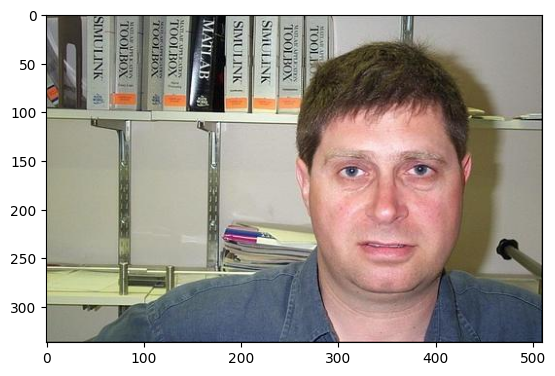

In [15]:
selected_image_id = int(input("Enter image ID: "))
sample_image, sample_label = dataset[selected_image_id]
plt.imshow(sample_image)
plt.show()


In [16]:
# Class transform to partition image into rows x cols grid


class GridPartition:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols

    def __call__(self, img):
        img_width, img_height = img.size
        cell_width = img_width // self.cols
        cell_height = img_height // self.rows

        grids = []
        for i in range(self.rows):
            for j in range(self.cols):
                left = j * cell_width
                top = i * cell_height
                right = left + cell_width
                bottom = top + cell_height
                grid = img.crop((left, top, right, bottom))
                grids.append(grid)

        return grids


### Feature model 1: Color moments

In [17]:
from scipy.stats import skew


def compute_color_moments(image):
    image = np.array(image)  # Convert PIL Image to NumPy array
    moments = []

    for channel in range(3):  # Iterate over RGB channels
        channel_data = image[:, :, channel]
        mean = np.mean(channel_data)
        std_dev = np.std(channel_data)
        skewness = skew(channel_data, axis=None)
        moments.append([mean, std_dev, skewness])

    return moments


# Iterate over grid cells and return as 1-d array for easier resizing by torch
def compute_color_moments_for_grid(grid):
    color_moments = [compute_color_moments(grid_cell) for grid_cell in grid]
    return np.array(color_moments).flatten()


In [18]:
def combine_color_moments(grid_color_moments):
    return torch.Tensor(grid_color_moments).view(
        10, 10, 3, 3
    )  # resize as needed: 10x10 grid, 3 channels per cell, 3 moments per channel


Composed color moment transform (CM10x10)

In [19]:
CM_transform = transforms.Compose(
    [
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(
            rows=10, cols=10
        ),  # partition into grid of 10 rows, 10 columns as a list
        compute_color_moments_for_grid,
        combine_color_moments,
    ]
)

if np.array(sample_image).shape[2] >= 3:
    # no color moments for grayscale images
    cm_fd = CM_transform(sample_image)
else:
    cm_fd = torch.zeros((10, 10, 3, 3)) #TODO: store with some flag to indicate grayscale

print(np.array(cm_fd))


[[[[ 1.00823334e+02  4.03585434e+01  1.39339343e-01]
   [ 9.93499985e+01  4.40474091e+01  1.59006089e-01]
   [ 9.40433350e+01  4.59179153e+01  9.95593667e-02]]

  [[ 1.30446671e+02  2.40076485e+01 -4.64996189e-01]
   [ 1.34526672e+02  2.45846004e+01 -4.56135452e-01]
   [ 1.28343338e+02  2.31468964e+01 -5.01845002e-01]]

  [[ 1.23833336e+02  3.58506927e+01 -1.03938901e+00]
   [ 1.28339996e+02  3.64046402e+01 -9.52629089e-01]
   [ 1.21106667e+02  3.44223099e+01 -9.30434644e-01]]

  [[ 9.60800018e+01  6.08619232e+01  6.41529337e-02]
   [ 1.00713333e+02  6.27334938e+01  6.39732033e-02]
   [ 1.00713333e+02  6.00332489e+01 -7.28099374e-03]]

  [[ 1.59759995e+02  3.47762718e+01 -1.13673592e+00]
   [ 1.64979996e+02  3.61011505e+01 -1.19473243e+00]
   [ 1.58046661e+02  3.68636818e+01 -1.20698023e+00]]

  [[ 1.63463333e+02  2.52233086e+01 -7.54342377e-01]
   [ 1.66543335e+02  2.43529892e+01 -9.96262252e-01]
   [ 1.61516663e+02  2.58279514e+01 -8.42239976e-01]]

  [[ 1.79143326e+02  2.27797298e+0

(note that skewness is NaN when all elements are equal i.e. std. dev. = 0)

#### Visualizing color moments - stacked bar chart

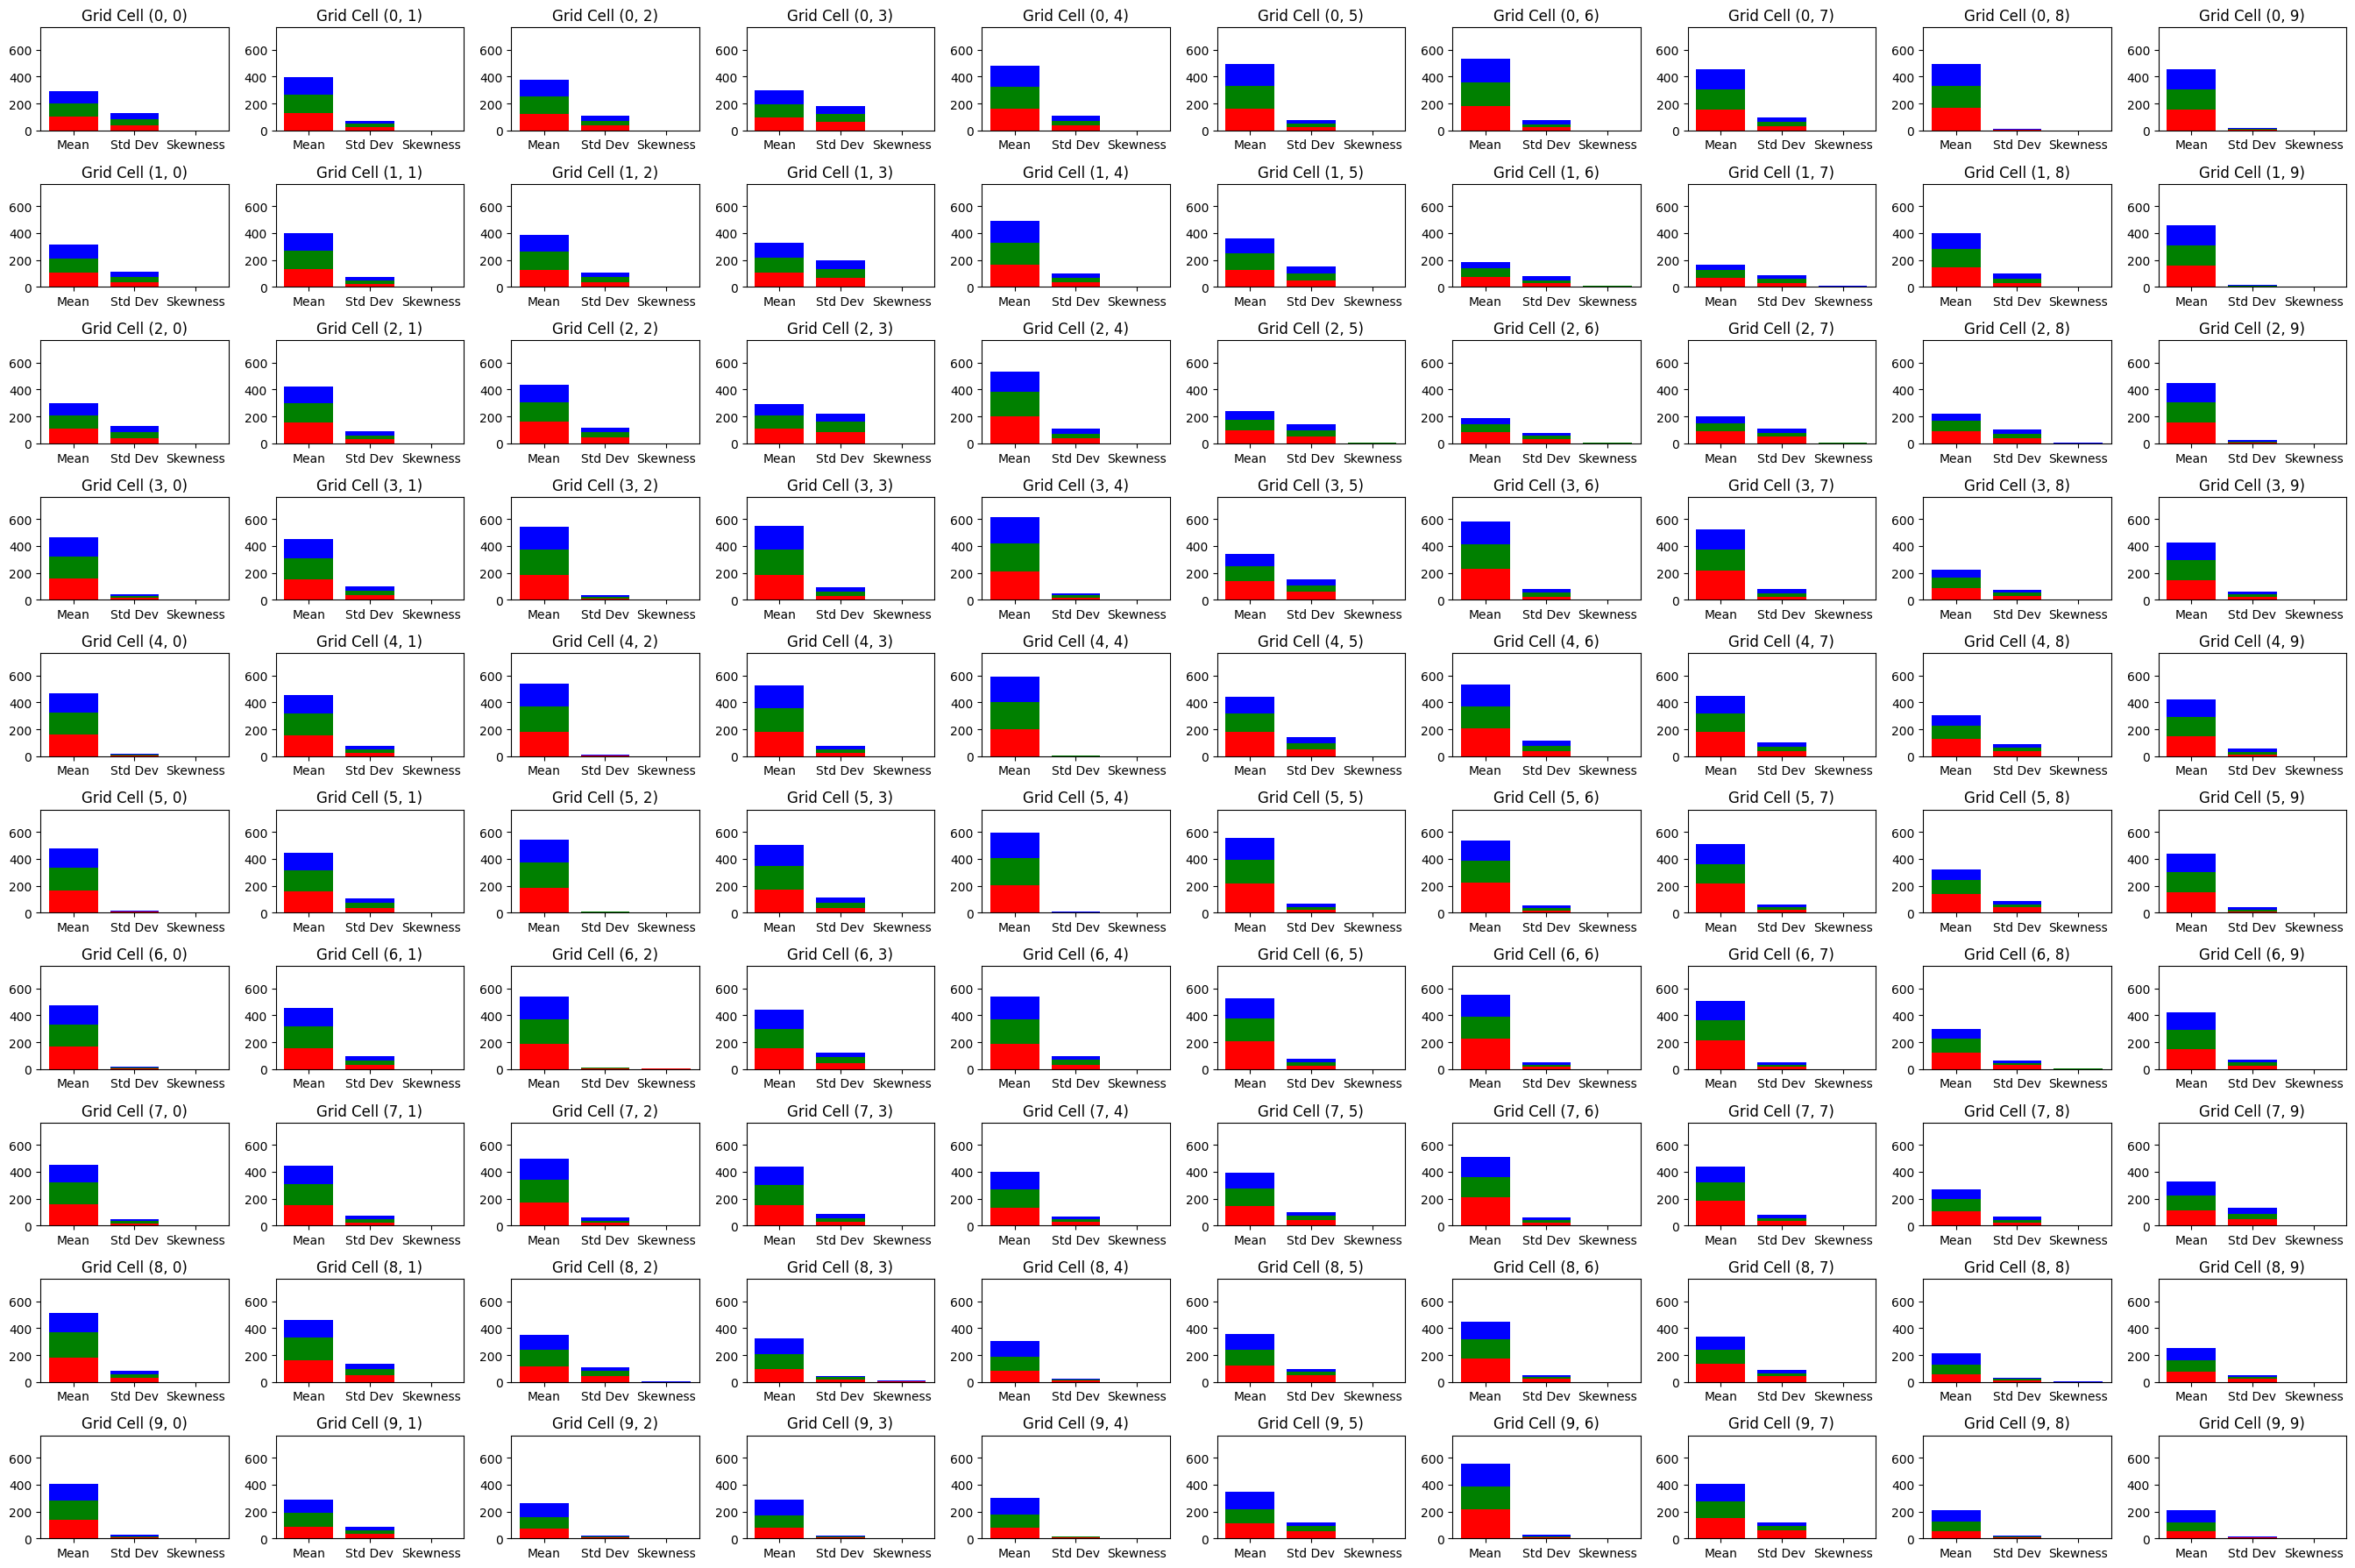

In [22]:
# cm_fd should be a NumPy array of shape (M, N, 3, 3), where (M, N) is the grid size

# Define the number of grid cells (M and N)
M, N = cm_fd.shape[:2]

# Create subplots for each color moment (mean, standard deviation, skewness)
fig, axes = plt.subplots(M, N, figsize=(27, 18))

# Loop through each grid cell and visualize the color moments as stacked bar charts
for i in range(M):
    for j in range(N):
        moments = cm_fd[i, j]
        colors = ["red", "green", "blue"]

        for c in range(3):
            ax = axes[i, j]
            ax.bar(
                ["Mean", "Std Dev", "Skewness"],
                moments[c],
                color=colors[c],
                bottom=np.sum(np.array(moments[:c]), axis=0),
            )  # stack channels
            ax.set_ylim(
                0, 3 * 255
            )  # since max possible meanset can be [255, 255, 255] for entirely white grid cell
            ax.set_title(f"Grid Cell ({i}, {j})")


# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


Feature model 2: Histogram Oriented Gradients (HOG)

In [23]:
def compute_gradient_histogram(grid_cell):
    histograms = []

    # Convert grid cell to NumPy array
    grid_array = np.array(grid_cell, dtype=np.uint8)

    # Compute the gradient using first-order central differences
    dx = cv2.Sobel(
        grid_array, cv2.CV_32F, dx=1, dy=0, ksize=1
    )  # first order x derivative = [-1, 0, 1]
    dy = cv2.Sobel(
        grid_array, cv2.CV_32F, dx=0, dy=1, ksize=1
    )  # first order y derivative = [-1, 0, 1]^T

    # Compute magnitude and direction of gradients
    magnitude = np.sqrt(dx**2 + dy**2)
    direction = np.arctan2(dy, dx) * 180 / np.pi  # in degrees

    # Compute HOG - 9 bins, counted across the range of -180 to 180 degrees, weighted by gradient magnitude
    histogram, _ = np.histogram(direction, bins=9, range=(-180, 180), weights=magnitude)

    histograms.append(histogram)

    return histograms


In [24]:
def compute_histograms_for_grid(grid):
    histograms = [compute_gradient_histogram(grid_cell) for grid_cell in grid]
    return np.array(histograms).flatten()


In [25]:
def combine_histograms(grid_histograms):
    return torch.Tensor(grid_histograms).view(10, 10, 9)


In [26]:
HOG_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # grayscale transform
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(
            rows=10, cols=10
        ),  # partition into grid of 10 rows, 10 columns as a list
        compute_histograms_for_grid,
        combine_histograms,
    ]
)

hog_fd = HOG_transform(sample_image)
print(np.array(hog_fd))


[[[5.48216125e+02 6.42108536e+01 2.22932739e+02 2.45502533e+02
   2.55311060e+03 1.45339050e+02 8.48154907e+02 2.85043427e+02
   1.66178992e+03]
  [8.04331360e+02 3.29335327e+02 5.74337769e+02 3.05416626e+02
   1.86223706e+03 4.26850159e+02 4.26308197e+02 2.55662262e+02
   2.21240479e+03]
  [2.62710547e+03 4.00985046e+02 5.62787354e+02 2.51098633e+02
   2.23010474e+03 5.16437683e+02 2.26072296e+02 6.93187714e+01
   1.58399817e+03]
  [1.22158350e+03 7.93739624e+02 8.10132507e+02 2.68848633e+02
   4.25773633e+03 1.47309338e+03 9.36701477e+02 7.28769592e+02
   1.49151575e+03]
  [1.89768347e+03 5.03877686e+02 7.52492310e+02 2.16811615e+02
   3.92073438e+03 5.32158630e+02 3.15780823e+02 1.37840530e+02
   3.03072119e+03]
  [1.29499219e+03 1.57916168e+02 5.01697113e+02 1.87355347e+02
   2.98734009e+03 2.50042191e+02 2.86111786e+02 1.06908493e+02
   1.42809778e+03]
  [4.06152992e+01 2.66091400e+02 2.19580469e+03 7.82842731e+00
   1.40000000e+01 1.43269005e+01 2.21193039e+02 1.43235718e+02
   3

Visualizing HOG as histograms

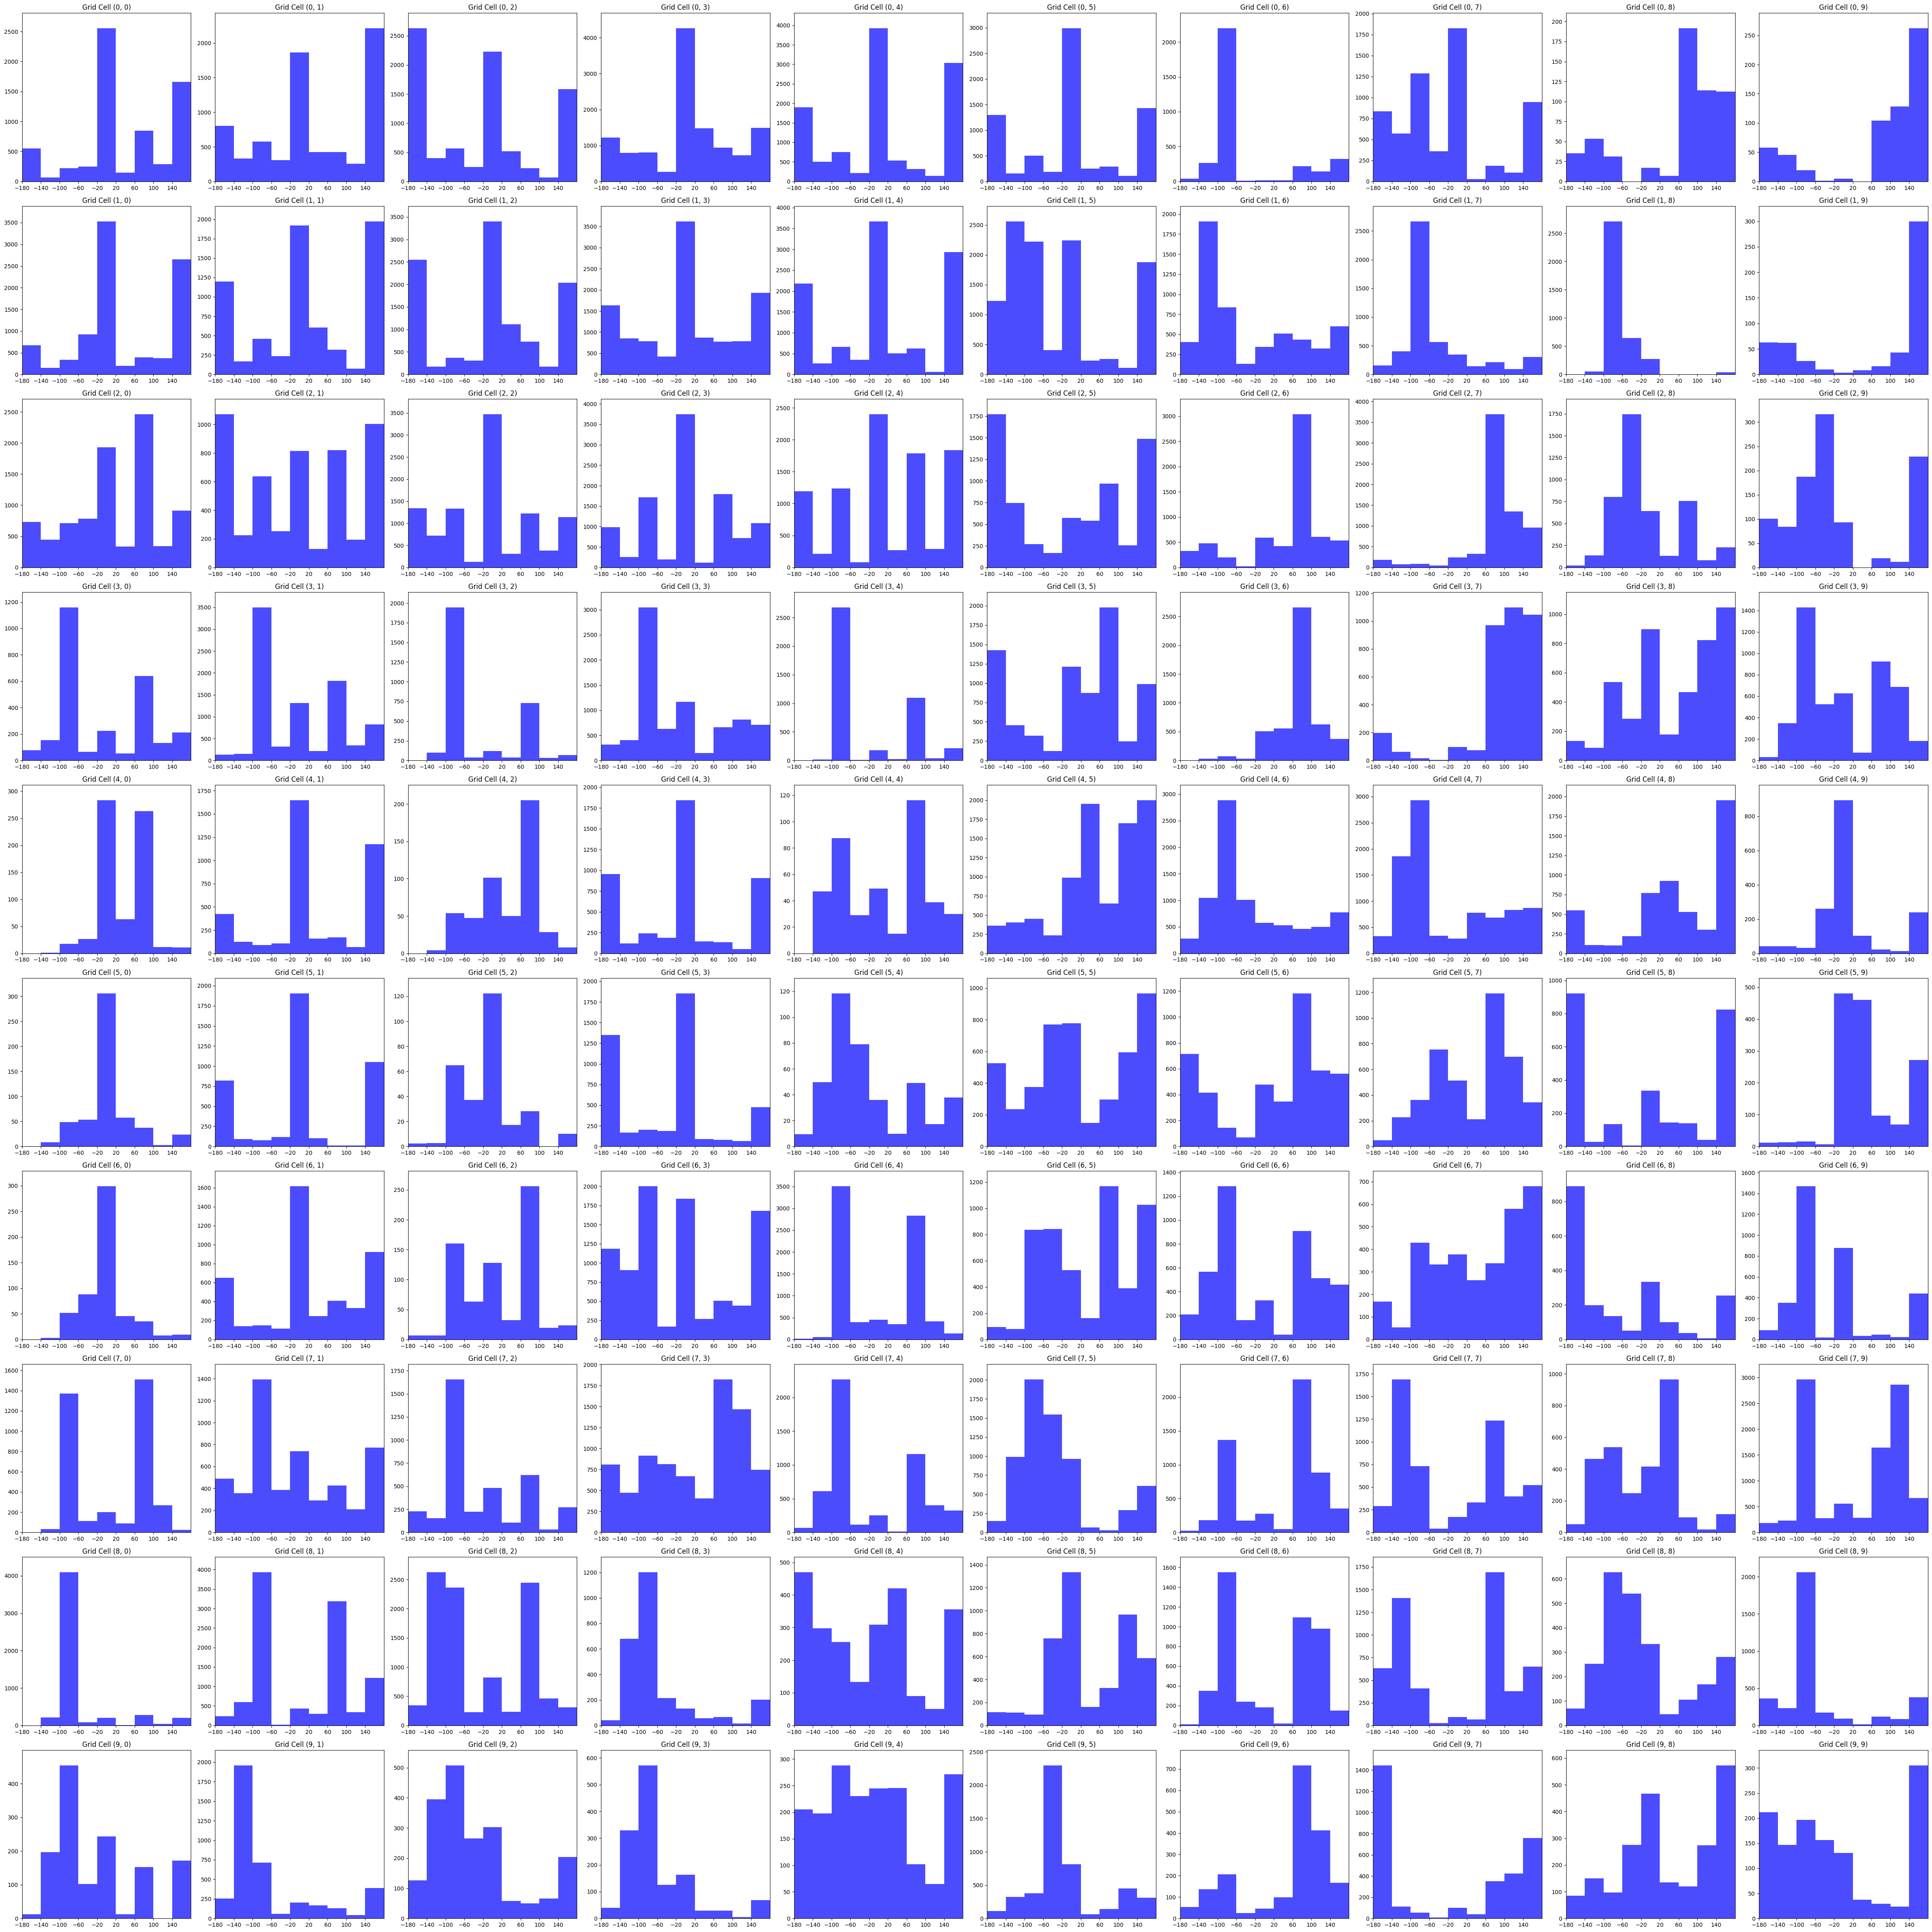

In [27]:
# # The 'hog' should now contain the 10x10x9 feature descriptor
# # Reshape it to a 10x10 grid of histograms, each of shape (9,)
histograms = np.array(hog_fd.reshape(10, 10, 9))

# # Visualize the histograms
fig, axes = plt.subplots(10, 10, figsize=(48, 48))
for i in range(10):
    for j in range(10):
        histogram = histograms[i, j]
        angles = np.linspace(-180, 180, 9, endpoint=False)

        axes[i, j].bar(angles, histogram, width=40, align="edge", color="b", alpha=0.7)
        axes[i, j].set_xlim(-180, 180)
        axes[i, j].set_ylim(0, np.max(histogram) * 1.1)
        axes[i, j].set_xticks([-180, -140, -100, -60, -20, 20, 60, 100, 140])
        axes[i, j].set_title(f"Grid Cell ({i}, {j})")

plt.tight_layout()
plt.show()


### Visualizing HOG gradient directions as an arrow overlay

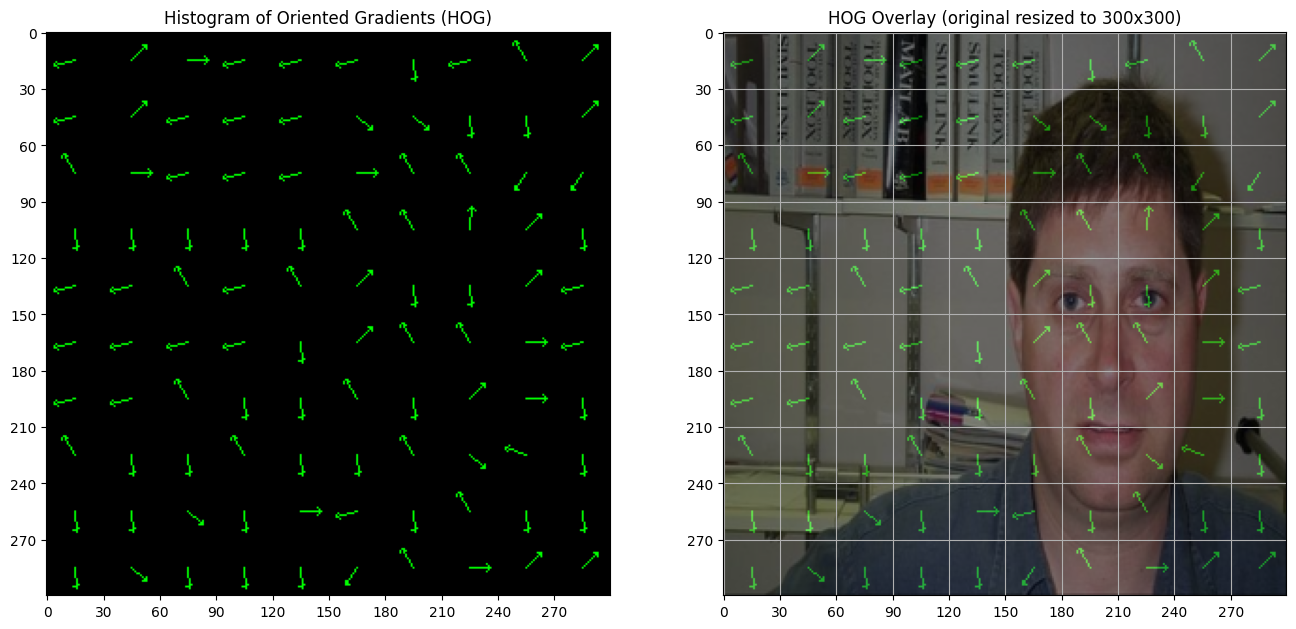

In [28]:
# Create a blank canvas to visualize the HOG features
block_size = 30
canvas = np.zeros((10 * block_size, 10 * block_size, 3), dtype=np.uint8)

# Define the arrow properties
base_arrow_length = block_size * 3 / 4  # Adjust as needed
arrow_color = (0, 255, 0)  # Green arrows for gradient direction

# Loop through each block in the HOG feature descriptor
for i in range(10):
    for j in range(10):
        block = hog_fd[i, j]
        x, y = j * block_size, i * block_size  # Top-left corner of the block

        # Compute the center position of the block
        center_x = x + block_size // 2
        center_y = y + block_size // 2

        # Find n most dominant directions (pairs of index and gradient magnitude in that direction)
        num_dir = 1
        dominant_directions = [pair for pair in sorted(
                list(enumerate(block)), key=lambda x: x[1], reverse=True
            )[:num_dir]
        ]

        for idx, (direction, magnitude) in enumerate(dominant_directions):
            arrow_thickness = num_dir - idx # decreasing thickness
            
            # Compute end points
            # arrow_start_x = int(
            #     center_x - ((base_arrow_length * np.cos(np.deg2rad(direction * 40))) / 2)
            # )
            # arrow_start_y = int(
            #     center_y - ((base_arrow_length * np.sin(np.deg2rad(direction * 40))) / 2)
            # )
            arrow_end_x = int(
                center_x
                + ((base_arrow_length * np.cos(np.deg2rad(direction * 40))) / 2)
            )
            arrow_end_y = int(
                center_y
                + ((base_arrow_length * np.sin(np.deg2rad(direction * 40))) / 2 )
            )

            # Draw the arrow on the canvas
            cv2.arrowedLine(
                canvas,
                (center_x, center_y),
                # (arrow_start_x, arrow_start_y),
                (arrow_end_x, arrow_end_y),
                arrow_color,
                thickness=arrow_thickness,
                tipLength=0.2,
            )

# Display the canvas with HOG arrows visualization alongside HOG overlay over resized image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=False)

ax1.imshow(canvas)
ax1.set_title('Histogram of Oriented Gradients (HOG)')

ax2.imshow(transforms.Resize((300,300))(sample_image))
ax2.imshow(canvas, alpha=0.5) # overlay HOG on image
# ax.imshow(transforms.Resize((300, 300))(sample_image))
ax2.set_title('HOG Overlay (original resized to 300x300)')

ax1.set_xticks(range(0, 300, 30))
ax1.set_yticks(range(0, 300, 30))
ax2.set_xticks(range(0, 300, 30))
ax2.set_yticks(range(0, 300, 30))
plt.grid()
plt.show()


## Working with ResNet50

In [29]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [30]:
import torchvision.models as models

# Load model
model = models.resnet50(models.ResNet50_Weights.DEFAULT)

# use GPU (Nvidia)
if torch.cuda.is_available():
    dev = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    dev = torch.device("cpu")

print(f"Using {dev}")
model = model.to(dev)

# ResNet architecture in brief
model.eval()


Using cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### ResNet50 - Feature extractor module (for ease of use - attach hooks at multiple layers at once)

In [31]:
# Generalized feature extractor module for any PyTorch model

class FeatureExtractor(torch.nn.Module):
    def __init__(self, model, layers):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {
            layer: torch.empty(0) for layer in layers
        }  # store layer outputs here

        # Create hooks for all specified layers at once
        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]  # get actual layer in the model
            layer.register_forward_hook(
                self.save_outputs_hook(layer_id)
            )  # register feature extractor hook on layer

    # Hook to save output of layer
    def save_outputs_hook(self, layer_id):
        def fn(_module, _input, output):
            self._features[layer_id] = output

        return fn

    # Forward pass returns extracted features
    def forward(self, x):
        _ = self.model(x)
        return self._features


Resize image to 224x224 with 3 channels for ResNet50

In [32]:
resized_image = (
    torch.Tensor(np.array(transforms.Resize((224, 224))(sample_image)).flatten())
    .view(1, 3, 224, 224)
    .to(dev)
)


In [33]:
# Attach all hooks on model and extract features

resnet_features = FeatureExtractor(model=model, layers=["avgpool", "layer3", "fc"])

features = resnet_features(resized_image)

print({name: output.shape for name, output in features.items()})


{'avgpool': torch.Size([1, 2048, 1, 1]), 'layer3': torch.Size([1, 1024, 14, 14]), 'fc': torch.Size([1, 1000])}


ResNet-AvgPool-1024

In [34]:
avgpool_2048 = features["avgpool"]

# Reshape the vector into row pairs of elements and average across rows
avgpool_1024_fd = torch.mean(avgpool_2048.view(-1, 2), axis=1)

print(avgpool_2048.flatten())
print(avgpool_1024_fd)


tensor([2.0626, 2.9191, 0.0000,  ..., 0.0000, 0.0000, 0.0689], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor([2.4909, 0.0000, 0.1396,  ..., 0.0000, 0.0137, 0.0344], device='cuda:0',
       grad_fn=<MeanBackward1>)


ResNet-Layer3-1024

In [35]:
layer3_1024_14_14 = features["layer3"]

# Reshape the vector into 1024 rows of 196 elements and average across rows
layer3_1024_fd = torch.mean(layer3_1024_14_14.view(1024, -1), axis=1)

print(layer3_1024_14_14)
print(layer3_1024_fd)


tensor([[[[ 57.0437,   0.0000,  26.1823,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  4.7055,  12.4462,  14.8685,  ...,  12.7924,  13.6380,  22.3323],
          [  6.3238,  15.3498,  20.3520,  ...,  14.7575,  15.0410,  24.1294],
          [  5.9188,  19.7761,  26.5747,  ...,  22.3662,  23.1224,  22.0713],
          ...,
          [ 14.3413,  16.9760,  23.3657,  ...,  20.4830,  20.2409,  16.4525],
          [ 11.7579,  26.0454,  24.9398,  ...,  33.5801,  26.6419,  15.0715],
          [ 14.4372,  26.8683,  23.2652,  ...,  23.0901,  19.9612,  12.6060]],

         [[  8.8508,  30.7673,

ResNet-FC-1000

In [47]:
fc_1000_fd = features['fc'].view(1000)

print(fc_1000_fd)

tensor([-1.3940e+01,  9.1132e+00,  6.1162e+00,  1.0792e+01,  3.3224e+00,
         1.9320e+01,  5.1049e+00,  4.7691e+00, -2.0881e+01,  2.0953e+01,
        -6.4812e+00, -3.3026e+01, -1.6057e+01, -5.4794e+00, -2.4443e+01,
        -1.4292e+01, -3.3535e+01, -5.7754e+00, -4.1393e+00,  4.7517e+00,
         6.6143e-02, -2.1278e+00, -3.6448e+00,  1.0082e+01, -1.7459e+00,
        -1.8159e+00, -3.3936e+01,  6.0654e+00,  2.0529e+01,  2.5779e+01,
        -1.7620e+01,  3.4377e+00, -6.0763e-01, -1.9230e+00,  1.4899e+01,
         9.7460e+00, -3.3783e+00, -1.4200e+01,  3.2699e+01, -1.3880e+00,
        -2.6002e+01,  1.8591e+01,  1.3840e+01,  3.0317e+01, -1.2746e+01,
        -1.6405e+01, -2.2140e+01, -1.4217e+01, -8.3123e+00,  2.9353e+00,
        -7.2378e+00,  2.7383e+00,  1.6914e+01,  2.3957e+01, -5.1461e+01,
         4.3536e+00, -1.3160e+01, -3.4496e+01,  4.0972e+00, -4.2697e+00,
         1.5591e+02,  2.1393e+01, -1.2135e+00, -1.8024e+01,  1.5190e+01,
         1.9532e+01, -2.9650e+00, -1.2248e+01, -1.4

In [48]:
print(cm_fd.numpy().shape)
print(hog_fd.numpy().shape)
print(avgpool_1024_fd.detach().cpu().numpy().shape)
print(layer3_1024_fd.detach().cpu().numpy().shape)
print(fc_1000_fd.detach().cpu().numpy().shape)

(10, 10, 3, 3)
(10, 10, 9)
(1024,)
(1024,)
(1000,)
